# Śledzenie rozgyrwki bilarda

## Import niezbędnych bibliotek

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import deque
from sklearn.cluster import KMeans

# import PIL
# import os
# import sys
# import glob
# import random

# from pprint import pprint
from ipywidgets import Video

import PIL
from IPython.display import display
# from PIL.ExifTags import TAGS

def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Analiza wideo

### Wczytanie wideo i jego podstawowych właściwości

In [4]:
video = cv2.VideoCapture('data/9-ball/video6.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))
print(f'Wysokość i szerokość obrazu: {height} x {width}')

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

Movie loaded :)
Wysokość i szerokość obrazu: 1054 x 1924
Liczba klatek na sekundę: 59.891696750902526


### Wyświetlenie analizowanego wideo

In [5]:
Video.from_file('data/9-ball/video1.mov')

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x00\x00qt  \x00\x00\x00\x08wide\x01\x02\xee\xc3mdat\x00\x01\x03…

### Poszukiwanie współrzędnych bil na filmie

### Wykorzystanie algorytmu CSRT do śledzenia znalezionych bili na filmie

In [6]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.legacy.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.legacy.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.TrackerCSRT_create()


In [46]:
def draw_bbox(frame, bbox, color=(255, 255, 255)):

    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, color, 2, 1)

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def circle_to_rectangle(circle, radius):
    return (int(circle[0]-radius), int(circle[1]-radius), int(2*radius),  int(2*radius))


def calculate_velocity(x, y, fps, n_frames):
  return np.sqrt(x**2 + y**2)/(n_frames/fps)

def collision(c1, c2, v1p, v1, v2p, v2, min_deg_tol, max_pos_tol, fps, n_frames):

    v1_val = calculate_velocity(v1[0], v1[1], fps, n_frames)
    v2_val = calculate_velocity(v2[0], v2[1], fps, n_frames)
    v1p_val = calculate_velocity(v1p[0], v1p[1], fps, n_frames)
    v2p_val = calculate_velocity(v2p[0], v2p[1], fps, n_frames)

    dp = v1[0] * v2[0] + v1[1] + v2[1]

    if distance(c1, c2) < max_pos_tol and dp > 0:

        return True
        # dp1 = v1[0] * v1p[0] + v1[1] + v1p[1]
        # den1 = v1_val * v1p_val

        # dp2 = v2[0] * v2p[0] + v2[1] + v2p[1]
        # den2 = v2_val * v2p_val
        # if dp1 / den1 < np.cos(min_deg_tol) or dp2 / den2 < np.cos(min_deg_tol):
        #     return True

    return False

def count_centroid(b):
    return [ int(b[0] + b[2]/2), int(b[1] + b[3]/2) ]

def find_circles(frame, max_r, min_r):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 

    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT, 1, 2 * min_r, param1 = 60, 
                param2 = 20, minRadius = min_r, maxRadius = max_r)
    
    circles = np.uint16(np.around(circles))
    
    return circles

def draw_points(frame, points, radius, thickness):

    for p in points:
        cv2.circle(frame, p, radius, (0, 0, 0), thickness)

def segment(frame, n_colors):

    board = cv2.resize(frame, None, fx=0.75, fy=0.75).astype(np.int32)

    board_pixels = board.reshape([-1, 3])
    model = KMeans(n_clusters=n_colors)
    model.fit(board_pixels)

    segments = model.predict(board_pixels)

    segments_colors = np.stack([board_pixels[segments==i].mean(0) for i in range(n_colors)], 0)
    colors = np.take(segments_colors, segments, 0)

    return colors.reshape(board.shape)

def find_luza(frame):

    filter = np.array([
        [-1, -1, -1], 
        [-1, 9, -1], 
        [-1, -1, -1]
    ]) 
    
    sharpen_img_1 = cv2.filter2D(frame, -1, filter)
    cimg = cv2.cvtColor(sharpen_img_1, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(cimg,7)
    circles_blur = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT,1,frame.shape[0]/3,
                            param1=60,param2=20,minRadius=35,maxRadius=50)
    pockets = np.uint16(np.around(circles_blur))

    return pockets

def in_pocket(bill_pos, pocket_pos, pocket_r, bill_r):

    dist = distance(bill_pos.astype(np.float32), pocket_pos.astype(np.float32))
    if dist < pocket_r:
        return True
    
    return False

In [21]:
video = cv2.VideoCapture('movies/video4.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')


Movie loaded :)
Liczba klatek na sekundę: 57.634408602150536


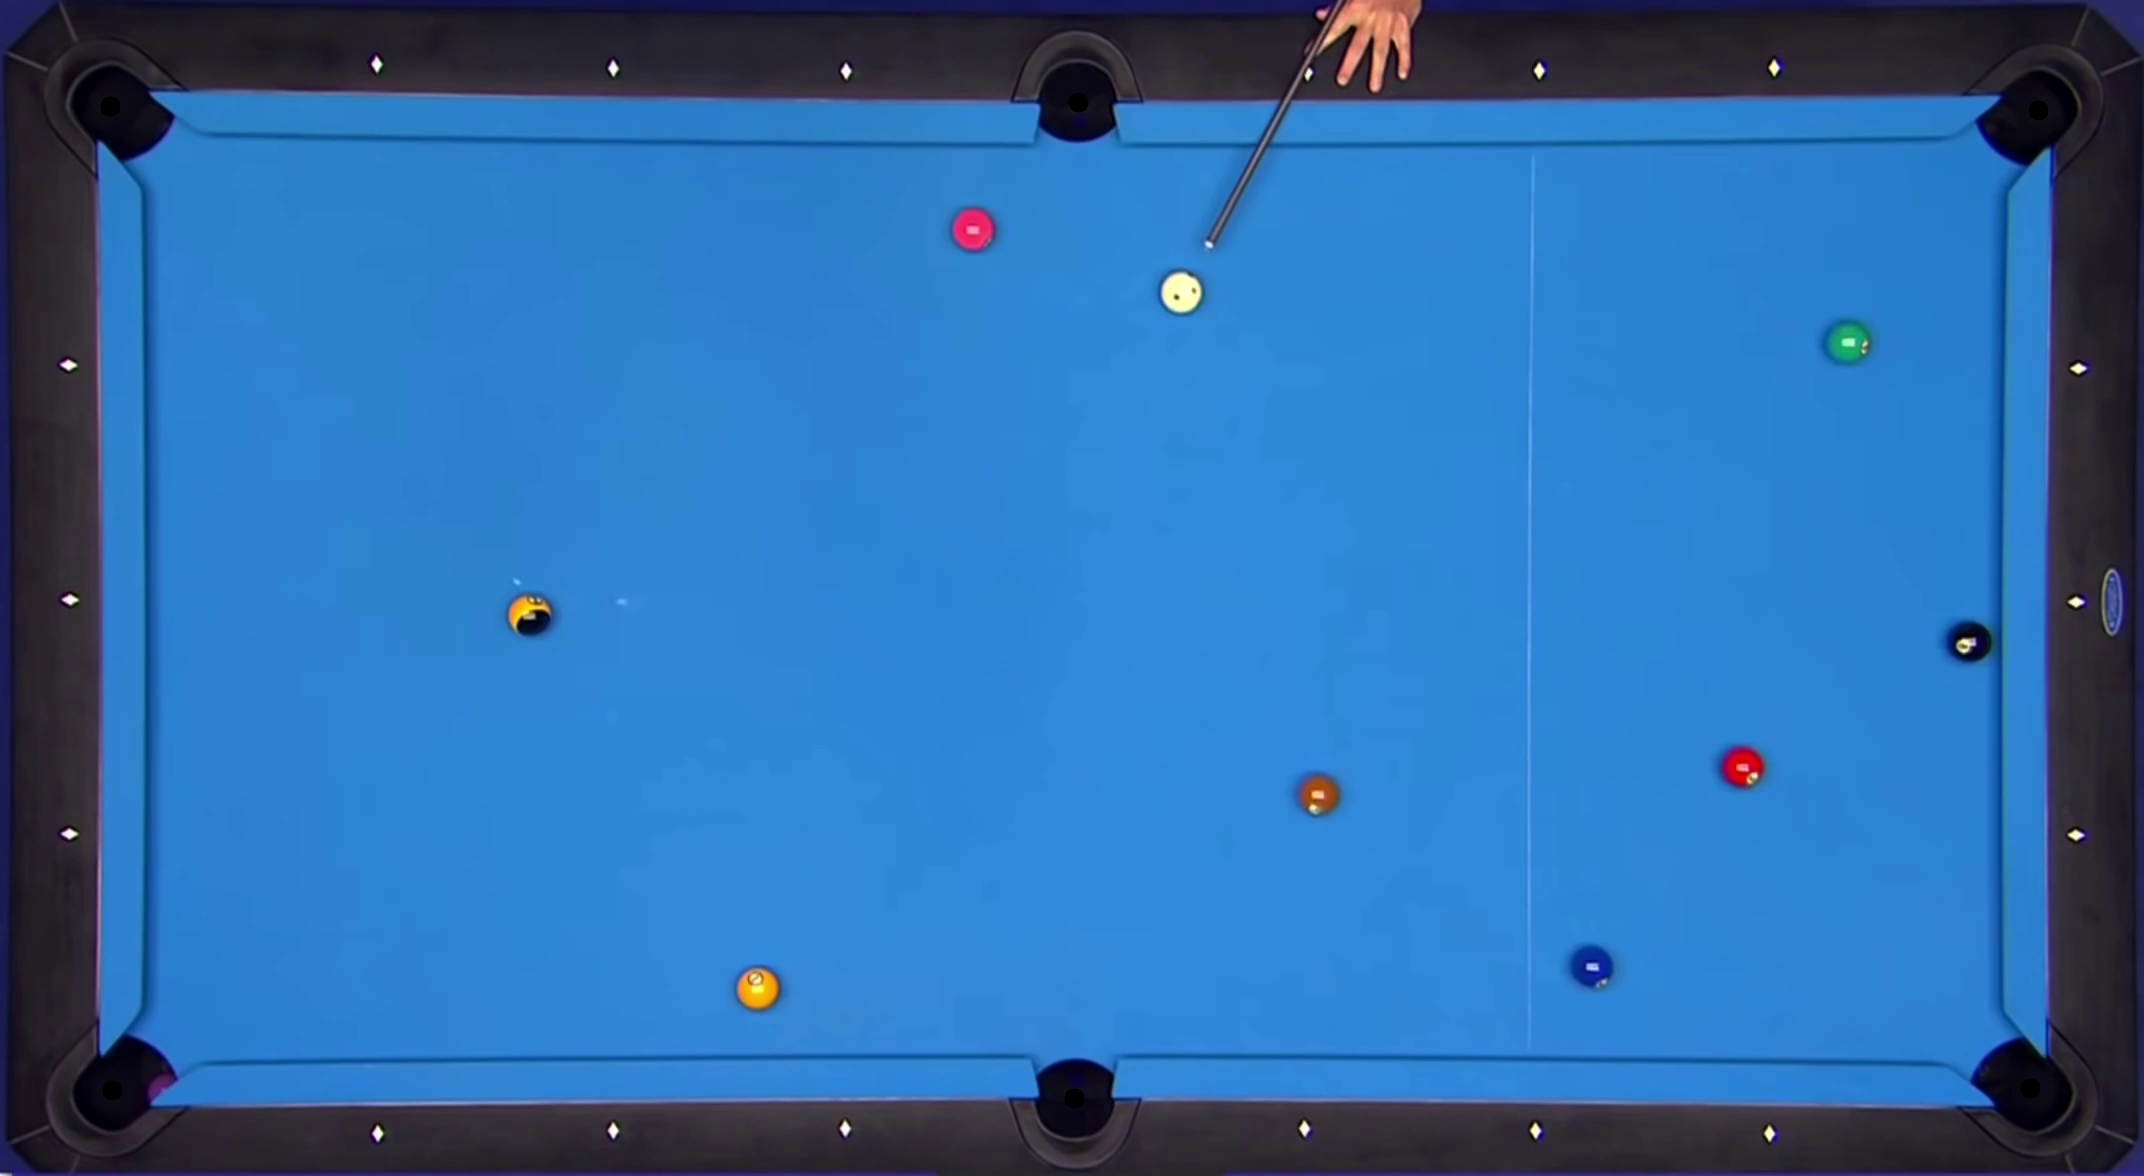

In [22]:
ret, frame = video.read()

pockets = find_luza(frame)

draw_points(frame, pockets[0, :, :2], 10, -1)

imshow(frame)

In [23]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 0
ANALYZE_TO = np.inf

video.set(1, ANALYZE_FROM)
ret, frame = video.read()

circles = find_circles(frame, 21, 13)
avg_r = np.average(circles[0, :, 2])

bills = []

for c in circles[0]:
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker_4.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))



frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    
    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            # if you want to draw velocities vectors
            # cv2.line(frame, pos[idx], (pos[idx] + np.average(last_frames_v[:, idx], axis=0)/6).astype(np.int32), (255, 0, 0), thickness=2)

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]


        for i in range(len(bills) - 1):
            for j in range(i + 1, len(bills)):

                b1 = pos[i]
                b2 = pos[j]
                v1 = vel[i]
                v2 = vel[j]
                v1p = last_frames_v[0][i]
                v2p = last_frames_v[0][j]

                if collision(b1, b2, v1p, v1, v2p, v2, MIN_DEG_TOL, MAX_POS_TOL, fps, HISTORY):
                    collisions.append([
                        frames_number, 
                    ])
                    for k in range(20):
                
                        cv2.putText(frame, 'COLLISION', b1 + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)

        video_tracker.write(frame)
    else:
        break

video_tracker.release()

[224]
[225]


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video_tracker_4.avi -y video_tracker_4.mp4

In [ ]:
Video.from_file('video_tracker_4.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0f\x08\xb9mdat\x0…

In [25]:
video = cv2.VideoCapture('movies/video1.mov')
if video.isOpened():
    print('Movie loaded :)')

width = int(video.get(3))
height = int(video.get(4))

fps = video.get(cv2.CAP_PROP_FPS)
print(f'Liczba klatek na sekundę: {fps}')

Movie loaded :)
Liczba klatek na sekundę: 59.21052631578947


In [76]:
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

HISTORY = 5
MOV_TOLERANCE = 3
MAX_POS_TOL = None
MIN_DEG_TOL = np.pi/6

ANALYZE_FROM = 50
ANALYZE_TO = 150

video.set(1, ANALYZE_FROM)
ret, frame = video.read()

circles = find_circles(frame, 21, 13)
avg_r = np.average(circles[0, :, 2])

pockets = find_luza(frame)
avg_pr = np.average(pockets[0, :, 2])

print(pockets)

bill_in_pocket = [0] * circles.shape[1]

bills = []

for i, c in enumerate(circles[0]):
    bills.append(create_tracker('CSRT'))
    bills[-1].init(frame, circle_to_rectangle(c, avg_r + 10))

    for p in pockets[0]:
        if in_pocket(c[:2], p[:2], p[2] + 40, c[2]):
            bill_in_pocket[i] = 1

print(bill_in_pocket)

MAX_POS_TOL = 3.5 * avg_r

video_tracker = cv2.VideoWriter('video_tracker_4.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))



frames_number = 0

collisions = []
last_frames_pos = np.zeros((HISTORY,len(bills),  2), dtype=np.int32)
last_frames_v = np.zeros((HISTORY, len(bills),  2), dtype=np.int32)

pos = np.zeros((len(bills), 2), dtype=np.int32)
vel = np.zeros((len(bills),2 ), dtype=np.int32)

for idx, b in enumerate(bills):
    _, bbox = b.update(frame)
    pos[idx] = count_centroid(bbox)

last_frames_pos = last_frames_pos + pos

while video.isOpened():

    frames_number += 1
    ret, frame = video.read()
    
    draw_points(frame, pockets[0, :, :2], int(avg_pr), thickness=4)

    if ret and frames_number < ANALYZE_TO - ANALYZE_FROM:

        bbox = None
        for idx, b in enumerate(bills):
            ok, bbox = b.update(frame)
            if ok: draw_bbox(frame, bbox, (0, 255, 0))

            pos[idx] = count_centroid(bbox)

        for idx, b in enumerate(bills):
            dist = distance(pos[idx], last_frames_pos[0][idx])
            if dist > MOV_TOLERANCE:
                
                vel[idx] = np.array([
                    pos[idx][0] - last_frames_pos[0][idx][0], pos[idx][1] - last_frames_pos[0][idx][1]
                ]) / (HISTORY/fps)
            else:
                vel[idx] = np.array([0,0])

            for p in pockets[0]:
                if in_pocket(pos[idx], p[:2], p[2] + 40, None) and bill_in_pocket[idx] == 0:
                    bill_in_pocket[idx] = 1
                    print(1)
                    for k in range(20):
                
                        cv2.putText(frame, 'SCORES', pos[idx] + 40, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        video_tracker.write(frame)
                    

        last_frames_pos = np.concatenate([last_frames_pos, [pos.copy()]], axis=0)
        last_frames_v = np.concatenate([last_frames_v, [vel.copy()]], axis=0)

        last_frames_pos = np.delete(last_frames_pos, 0, axis=0)
        last_frames_v = np.delete(last_frames_v, 0, axis=0)

        bill_pos = last_frames_pos[-1][0]
        bill_v = last_frames_v[-1][0]



        video_tracker.write(frame)
    else:
        break

video_tracker.release()

[[[1074  100   42]
  [2028 1086   49]
  [ 110  106   40]
  [2036  110   40]
  [1072 1098   43]
  [ 116 1088   44]]]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
1


In [77]:
!ffmpeg -hide_banner -loglevel error -i video_tracker_4.avi -y video_tracker_1.mp4
Video.from_file('video_tracker_1.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\x98\xdfmdat\x0…